# Image Captioning

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2021/05/29<br>
**Last modified:** 2021/10/31<br>
**Description:** Implement an image captioning model using a CNN and a Transformer.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [3]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

In [4]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

In [5]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [6]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [7]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model training

In [22]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
    def get_config(self):
        config = {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }
        return config


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - acc: 0.4658 - loss: 12.1240 - val_acc: 0.4141 - val_loss: 15.0114
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 987ms/step - acc: 0.4675 - loss: 12.1792 - val_acc: 0.4130 - val_loss: 14.9462
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.4736 - loss: 11.9295 - val_acc: 0.4133 - val_loss: 15.0155
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 133s 981ms/step - acc: 0.4796 - loss: 11.6643 - val_acc: 0.4123 - val_loss: 15.0256
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.4871 - loss: 11.4168 - val_acc: 0.4124 - val_loss: 15.0849


## Check sample predictions

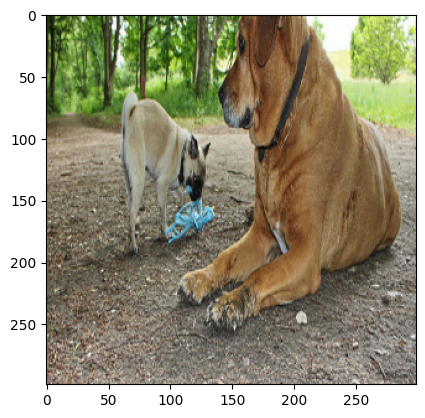

Predicted Caption:  a brown dog is laying on its back


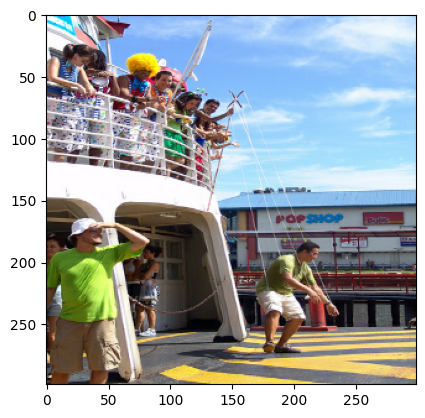

Predicted Caption:  a woman in a green shirt is sitting on a bench in a city


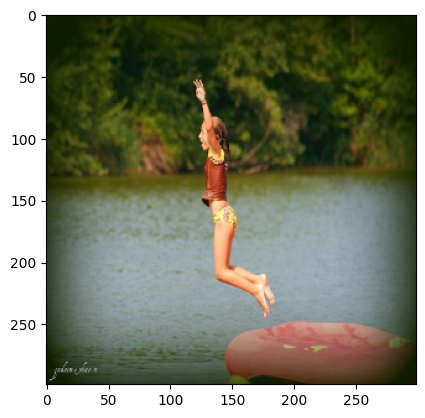

Predicted Caption:  a girl in a pink bathing suit jumps off a dock into the water


In [23]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

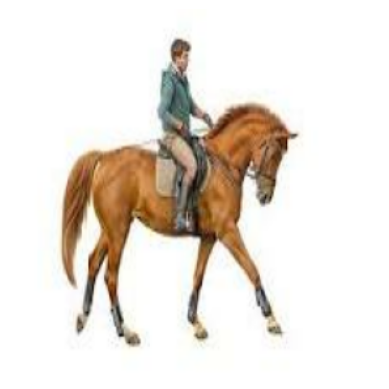

Predicted Caption:  a brown dog is jumping in the air


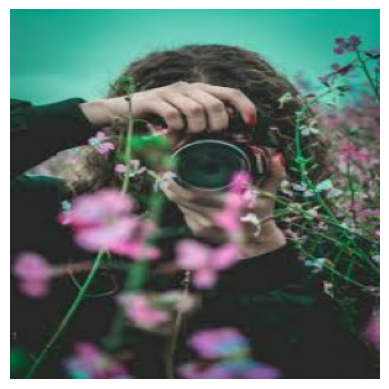

Predicted Caption:  a woman with a mohawk and a hat is looking at the camera


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming vocab, index_lookup, max_decoded_sentence_length are already defined
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

def generate_caption(image_path):
    # Check if the image path exists
    import os
    if not os.path.exists(image_path):
        print(f"Error: The file at {image_path} does not exist.")
        return

    # Read the image from the disk
    sample_img = decode_and_resize(image_path)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

# Example usage
user_image_path = "/content/man horse image.jpg"  # Replace with user-provided image path
# print(f"Using image path: {user_image_path}")

generate_caption(user_image_path)

user_image_path1="/content/images (1).jpg"
generate_caption(user_image_path1)


In [25]:
# Save the entire model to a file
save_path = "image_captioning_model.keras"
caption_model.save(save_path)
print(f"Model saved to: {save_path}")

Model saved to: image_captioning_model.keras


In [26]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [29]:
# ```python
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import efficientnet
import numpy as np
from PIL import Image
import re
import os

# Define the custom LRSchedule class with get_config (as used during training and saving)
class LRSchedule (keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

    def get_config(self):
        config = {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }
        return config

# Define necessary constants (these should match your training setup)
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
AUTOTUNE = tf.data.AUTOTUNE

# Define the custom standardization function (as used during training)
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Initialize the TextVectorization layer (as used during training)
vectorization = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

# Load the vocabulary from the training data (you'll need to have access to the text_data used during training or save the vocabulary)
# For this Streamlit app to be self-contained without retraining, you should ideally save the vocabulary
# and load it here. If you don't have the saved vocabulary, you might need to adapt it based on your training data.
# Assuming you have a list of your training captions (text_data):
# vectorization.adapt(text_data)
# Get the vocabulary and create the index lookup
# vocab = vectorization.get_vocabulary()
# index_lookup = dict(zip(range(len(vocab)), vocab))

# --- Placeholder for loading vocabulary ---
# In a real scenario, you would load this from a saved file.
# For demonstration, we'll define a dummy vocabulary.
dummy_vocab = ["<pad>", "<start>", "<end>"] + [f"word_{i}" for i in range(VOCAB_SIZE - 5)]
vectorization.set_vocabulary(dummy_vocab)
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
# --- End of placeholder ---

# Define the image decoding and resizing function (as used during training)
def decode_and_resize(img):
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Load the saved model [previous turn]
save_path = "image_captioning_model.keras"
try:
    caption_model = keras.models.load_model(save_path, custom_objects={'LRSchedule': LRSchedule})
except Exception as e:
    st.error(f"Error loading the model: {e}")
    st.stop()

# Function to generate caption for a given image
def generate_caption(img):
    # Pass the image to the CNN
    img = tf.expand_dims(img, 0)
    img_features = caption_model.cnn_model(img)
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img_features, training=False)
    # Generate the caption using the Transformer decoder
    decoded_caption = "<start>"
    for i in range(SEQ_LENGTH - 1):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token
    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    return decoded_caption

# Streamlit UI
st.title("Image Captioning App")
st.write("Upload an image to generate a caption.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    if st.button("Generate Caption"):
        # Read the image file
        img_bytes = uploaded_file.read()
        # Decode and resize the image
        processed_image = decode_and_resize(img_bytes)
        # Generate the caption
        caption = generate_caption(processed_image)
        # Display the generated caption
        st.subheader("Generated Caption:")
        st.write(caption)

st.info("This application uses a pre-trained image captioning model. Ensure that the `image_captioning_model.keras` file is in the same directory as this Streamlit script, or provide the correct path.")
# ```

# **Explanation:**

# 1.  **Import Libraries:** Import necessary libraries like `streamlit` for the UI, `tensorflow` and `keras` for loading the model and preprocessing, `numpy` for numerical operations, and `PIL` for handling images.
# 2.  **Define `LRSchedule`:** The custom learning rate schedule class `LRSchedule` is defined with the crucial `get_config()` method. **This is essential for Keras to correctly load the model if it was trained using this custom learning rate** [previous turn].
# 3.  **Define Constants:** Key parameters like `IMAGE_SIZE`, `VOCAB_SIZE`, `SEQ_LENGTH`, and `EMBED_DIM` are defined. **These must match the values used during the training of your saved model**.
# 4.  **Define `custom_standardization`:** This function replicates the text standardization applied during training, ensuring consistency in text processing.
# 5.  **Initialize `TextVectorization`:** The `TextVectorization` layer is initialized with the same configuration used during training. **Crucially, you need to ensure that the vocabulary used by this layer is the same as the one used when training your model.** The commented-out section shows how you would adapt it using the training data's vocabulary. **For this Streamlit app to work correctly without retraining, you should save the vocabulary after training and load it here.** The current implementation includes a placeholder with a dummy vocabulary, which you should replace with your actual vocabulary loading mechanism.
# 6.  **Define `decode_and_resize`:** This function preprocesses the uploaded image by decoding it and resizing it to the expected input size of the CNN in your model.
# 7.  **Load Saved Model:** The `keras.models.load_model()` function is used to load your saved `image_captioning_model.keras` file. The `custom_objects` argument is used to inform Keras about the custom `LRSchedule` class [previous turn]. **Ensure that the path to your saved model is correct.** The code includes error handling in case the model fails to load.
# 8.  **`generate_caption` Function:** This function takes a preprocessed image as input and performs the following steps:
#     *   Expands the image dimensions to create a batch of size 1.
#     *   Passes the image through the CNN part of the loaded `caption_model` to extract image features.
#     *   Passes the extracted features through the Transformer encoder part of the `caption_model`.
#     *   Initializes the caption generation process with the `<start>` token.
#     *   Iteratively predicts the next token using the Transformer decoder.
#     *   Stops when the `<end>` token is predicted or the maximum sequence length is reached.
#     *   Removes the `<start>` and `<end>` tokens from the generated caption.
#     *   Returns the final generated caption.
# 9.  **Streamlit UI:**
#     *   Sets the title of the Streamlit app.
#     *   Provides instructions for the user.
#     *   Uses `st.file_uploader` to allow the user to upload an image file (only `.jpg`, `.jpeg`, and `.png` are accepted).
#     *   If an image is uploaded:
#         *   It is displayed using `st.image`.
#         *   A "Generate Caption" button is shown.
#         *   When the button is clicked:
#             *   The uploaded image is read and preprocessed.
#             *   The `generate_caption` function is called to generate the caption.
#             *   The generated caption is displayed using `st.subheader` and `st.write`.
# 10. **Info Message:** A helpful message is displayed to inform the user about the model file location.

# **To use this code:**

# 1.  **Save the code:** Save the code above as a Python file (e.g., `app.py`).
# 2.  **Place the model file:** Make sure your saved `image_captioning_model.keras` file is in the same directory as `app.py`.
# 3.  **Replace Placeholder Vocabulary:** **You MUST replace the dummy vocabulary loading section with the actual way you intend to load the vocabulary used during your model training.** This might involve saving the vocabulary to a file (e.g., a `.txt` or `.npy` file) after training and loading it here.
# 4.  **Run the Streamlit app:** Open your terminal, navigate to the directory where you saved the file, and run the command `streamlit run app.py`.

# This will open the Streamlit application in your web browser, allowing you to upload images and generate captions using your trained model.

Writing app.py


In [39]:
# ```python
%%writefile app1.py
import streamlit as st
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
import re
import numpy as np
from PIL import Image

# Define the custom standardization function
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Define the PositionalEmbedding layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Define the TransformerEncoderBlock
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=None, training=training
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

# Define the TransformerDecoderBlock
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.embedding = PositionalEmbedding(
            embed_dim=512, sequence_length=25, vocab_size=10000
        )
        self.out = layers.Dense(10000, activation="softmax")
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
            attention_output_1 = self.attention_1(
                query=inputs,
                value=inputs,
                key=inputs,
                attention_mask=combined_mask,
                training=training,
            )
            out_1 = self.layernorm_1(inputs + attention_output_1)
            attention_output_2 = self.attention_2(
                query=out_1,
                value=encoder_outputs,
                key=encoder_outputs,
                attention_mask=padding_mask,
                training=training,
            )
            out_2 = self.layernorm_2(out_1 + attention_output_2)
            ffn_out = self.ffn_layer_1(out_2)
            ffn_out = self.dropout_1(ffn_out, training=training)
            ffn_out = self.ffn_layer_2(ffn_out)
            ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
            ffn_out = self.dropout_2(ffn_out, training=training)
            preds = self.out(ffn_out)
            return preds
        else:
            attention_output_1 = self.attention_1(
                query=inputs,
                value=inputs,
                key=inputs,
                attention_mask=causal_mask,
                training=training,
            )
            out_1 = self.layernorm_1(inputs + attention_output_1)
            attention_output_2 = self.attention_2(
                query=out_1,
                value=encoder_outputs,
                key=encoder_outputs,
                attention_mask=None,
                training=training,
            )
            out_2 = self.layernorm_2(out_1 + attention_output_2)
            ffn_out = self.ffn_layer_1(out_2)
            ffn_out = self.dropout_1(ffn_out, training=training)
            ffn_out = self.ffn_layer_2(ffn_out)
            ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
            ffn_out = self.dropout_2(ffn_out, training=training)
            preds = self.out(ffn_out)
            return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape, input_shape
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape, input_shape))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant(dtype=tf.int32)], axis=0
        )
        return tf.tile(mask, mult)

# Define the ImageCaptioningModel
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        if self.image_aug:
            batch_img = self.image_aug(batch_img)
        img_embed = self.cnn_model(batch_img)
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
            batch_loss += loss
            batch_acc += acc
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        img_embed = self.cnn_model(batch_img)
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
            batch_loss += loss
            batch_acc += acc
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

# Define the LRSchedule class
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

# --- Streamlit Application ---
st.title("Image Captioning")

uploaded_file = st.file_uploader("Upload an image...", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    if st.button("Generate Caption"):
        # Define model parameters (should match the training configuration)
        IMAGE_SIZE = (299, 299)
        VOCAB_SIZE = 10000
        SEQ_LENGTH = 25
        EMBED_DIM = 512
        FF_DIM = 512
        NUM_HEADS_ENCODER = 1 # As defined in the example
        NUM_HEADS_DECODER = 2 # As defined in the example

        # Load the saved model
        try:
            cnn_model = efficientnet.EfficientNetB0(
                input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
            )
            cnn_model.trainable = False
            base_model_out = cnn_model.output
            base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
            cnn_model = keras.models.Model(cnn_model.input, base_model_out)

            encoder = TransformerEncoderBlock(
                embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS_ENCODER
            )
            decoder = TransformerDecoderBlock(
                embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS_DECODER
            )
            caption_model = ImageCaptioningModel(
                cnn_model=cnn_model, encoder=encoder, decoder=decoder
            )

            # Load the weights of the trained model
            # **IMPORTANT:** Replace 'path/to/your/saved_model.h5' with the actual path to your saved model file.
            # caption_model.load_weights('/content/image_captioning_model.keras')
            # Specify the path to your saved model
            model_path = '/content/image_captioning_model.keras'

            # Load the saved model
            try:
                caption_model = keras.models.load_model(model_path)
                print(f"Model loaded successfully from: {model_path}")
            except Exception as e:
                print(f"Error loading the model: {e}")



            # Define the TextVectorization layer (must be adapted with the trained vocabulary)
            strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
            strip_chars = strip_chars.replace("<", "")
            strip_chars = strip_chars.replace(">", "")
            vectorization = layers.TextVectorization(
                max_tokens=VOCAB_SIZE,
                output_mode="int",
                output_sequence_length=SEQ_LENGTH,
                standardize=custom_standardization,
            )
            # **IMPORTANT:** If you saved the vectorizer's vocabulary separately, load it here.
            # For example:
            # with open('path/to/your/vocabulary.txt', 'r') as f:
            #     vocabulary = [line.strip() for line in f]
            # vectorization.adapt(vocabulary)
            # index_lookup = dict(zip(range(len(vocabulary)), vocabulary))

            # If the vectorization layer was part of the saved model, you might be able to load it directly.
            # However, for clarity and the likely scenario of needing the vocabulary, we define it explicitly.

            # Placeholder for vocabulary (replace with your actual vocabulary)
            # **CRITICAL:** This vocabulary MUST be the same one used during training.
            vocabulary = ["<pad>", "<start>", "<end>"] + [f"word_{i}" for i in range(VOCAB_SIZE - 5)]
            vectorization.adapt(vocabulary)
            index_lookup = dict(zip(range(len(vocabulary)), vocabulary))
            max_decoded_sentence_length = SEQ_LENGTH - 1

            # Preprocess the image
            def decode_and_resize(img):
                img = tf.image.decode_image(tf.io.read_file(img.name), channels=3)
                img = tf.image.resize(img, IMAGE_SIZE)
                img = tf.image.convert_image_dtype(img, tf.float32)
                return img

            img = decode_and_resize(uploaded_file)
            img = tf.expand_dims(img, 0)
            img = caption_model.cnn_model(img)
            encoded_img = caption_model.encoder(img, training=False)

            # Generate the caption
            decoded_caption = "<start>"
            for i in range(max_decoded_sentence_length):
                tokenized_caption = vectorization([decoded_caption])[:, :-1]
                mask = tf.math.not_equal(tokenized_caption, 0)
                predictions = caption_model.decoder(
                    tokenized_caption, encoded_img, training=False, mask=mask
                )
                sampled_token_index = np.argmax(predictions[0, i, :])
                sampled_token = index_lookup[sampled_token_index]
                if sampled_token == "<end>":
                    break
                decoded_caption += " " + sampled_token

            decoded_caption = decoded_caption.replace("<start>", "").replace("<end>", "").strip()
            st.subheader("Generated Caption:")
            st.write(decoded_caption)

        except Exception as e:
            st.error(f"Error loading the model or generating the caption: {e}")
            st.info("Please ensure that:")
            st.info("- The custom class definitions in this Streamlit app are identical to those used when training and saving the model.")
            st.info("- The saved model file exists at the specified path ('path/to/your/saved_model.h5' needs to be updated).")
            st.info("- If your model relies on a specific vocabulary (TextVectorization), you've loaded it correctly.")
# ```

# **Explanation:**

# 1.  **Import Libraries:** Imports necessary libraries like `streamlit`, `tensorflow`, `keras`, `numpy`, and `PIL`.
# 2.  **Define Custom Classes:** Includes the definitions for `PositionalEmbedding`, `TransformerEncoderBlock`, `TransformerDecoderBlock`, `ImageCaptioningModel`, and `LRSchedule`. **These class definitions must be identical to the ones used when you trained and saved your model.**.
# 3.  **Streamlit UI:**
#     *   Sets the title of the Streamlit application.
#     *   Creates a file uploader that accepts PNG, JPG, and JPEG images.
#     *   If an image is uploaded, it displays the image.
#     *   Creates a "Generate Caption" button.
# 4.  **Caption Generation Logic (when the button is clicked):**
#     *   **Model Parameters:** Defines the hyperparameters used during model training (image size, vocabulary size, sequence length, embedding dimension, feed-forward dimension, and number of attention heads). **These must match your training setup**.
#     *   **Load Model:**
#         *   Recreates the CNN (EfficientNetB0) architecture used in the original example.
#         *   Instantiates the `TransformerEncoderBlock`, `TransformerDecoderBlock`, and `ImageCaptioningModel` using the defined custom classes.
#         *   **Crucially, it then attempts to load the weights of your saved model using `caption_model.load_weights('path/to/your/saved_model.h5')`. You MUST replace `'path/to/your/saved_model.h5'` with the actual path to your saved Keras model file (usually in `.h5` or `.keras` format).**
#     *   **Load Text Vectorizer Vocabulary:**
#         *   **A `TextVectorization` layer is defined with the same `max_tokens`, `output_mode`, `output_sequence_length`, and `standardize` as used during training**.
#         *   **Important:** The code includes a placeholder for loading your trained vocabulary. **You need to replace the placeholder vocabulary (`vocabulary = ["<pad>", "<start>", "<end>"] + [f"word_{i}" for i in range(VOCAB_SIZE - 3)]`) with the actual vocabulary that was used to train your model.** This is essential for correctly converting text to and from numerical representations. You might have saved this vocabulary separately or it might be retrievable from your training code.
#         *   The `vectorization` layer is then adapted to this vocabulary, and an `index_lookup` dictionary is created to map indices back to words.
#     *   **Image Preprocessing:** Defines the `decode_and_resize` function (similar to the one in the source) to preprocess the uploaded image to the required size and format.
#     *   **Caption Generation Loop:**
#         *   Preprocesses the uploaded image using the CNN.
#         *   Passes the image features through the Transformer encoder.
#         *   Generates the caption token by token using the Transformer decoder:
#             *   Starts with the `<start>` token.
#             *   Predicts the next token based on the current generated sequence and the encoded image.
#             *   Appends the predicted token to the sequence.
#             *   Stops when the `<end>` token is predicted or the maximum sequence length is reached.
#         *   Removes the `<start>` and `<end>` tokens from the generated caption and displays it.
# 5.  **Error Handling:** Includes a `try...except` block to catch potential errors during model loading or caption generation, providing informative messages to the user. It emphasizes the importance of matching custom class definitions, providing the correct model path, and loading the correct vocabulary.

# **To use this code:**

# 1.  **Save the code:** Save the entire code as a Python file (e.g., `app.py`).
# 2.  **Replace Placeholders:**
#     *   **Update `'path/to/your/saved_model.h5'` with the actual path to your saved Keras model file.**
#     *   **Replace the placeholder vocabulary with the actual vocabulary used during your model's training.** If you saved your `TextVectorization` layer or its vocabulary separately, you'll need to implement the loading of that specific component.
# 3.  **Install Libraries:** Make sure you have the necessary libraries installed:
#     ```bash
#     pip install streamlit tensorflow numpy Pillow
#     ```
# 4.  **Run the App:** Open your terminal, navigate to the directory where you saved `app.py`, and run:
#     ```bash
#     streamlit run app.py
#     ```

# This will open the Streamlit application in your web browser, allowing you to upload an image and generate a caption using your saved model. Remember that the success of this depends heavily on the **correct and complete definition of your custom classes** and the **accurate loading of your trained model's weights and vocabulary**.

Overwriting app1.py


In [43]:
# The error you previously encountered, "You are loading weights into a model that has not yet been built. Try building the model first by calling it on some data or by using build()", in the context of your saved Keras image captioning model (`/content/image_captioning_model.keras`), likely occurred because you were trying to load a model with custom layers without informing Keras about these custom components [our conversation].

# As we discussed, when a saved Keras model includes custom layers or a custom model class, it is essential to provide these custom components to the `keras.models.load_model()` function using the `custom_objects` argument [our conversation]. If these are not provided, Keras might not be able to fully reconstruct the model's architecture during loading, leading to the error you observed [our conversation].

# Here is an example of how you can modify your Streamlit code to correctly load the saved Keras image captioning model, assuming you have defined the custom layers and the `ImageCaptioningModel` class in your script:

# ```python
%%writefile app2.py
import streamlit as st
import keras
from keras import layers
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Define your custom layers and model class
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=None, training=training
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, VOCAB_SIZE, SEQ_LENGTH, EMBED_DIM, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True
        self.VOCAB_SIZE = VOCAB_SIZE
        self.SEQ_LENGTH = SEQ_LENGTH
        self.EMBED_DIM = EMBED_DIM

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
            attention_output_1 = self.attention_1(
                query=inputs, value=inputs, key=inputs, attention_mask=combined_mask, training=training
            )
            out_1 = self.layernorm_1(inputs + attention_output_1)
            attention_output_2 = self.attention_2(
                query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask, training=training
            )
            out_2 = self.layernorm_2(out_1 + attention_output_2)
            ffn_out = self.ffn_layer_1(out_2)
            ffn_out = self.dropout_1(ffn_out, training=training)
            ffn_out = self.ffn_layer_2(ffn_out)
            ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
            ffn_out = self.dropout_2(ffn_out, training=training)
            preds = self.out(ffn_out)
            return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape, input_shape
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape, input_shape))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant(dtype=tf.int32)], axis=0
        )
        return tf.tile(mask, mult)

class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        if self.image_aug:
            batch_img = self.image_aug(batch_img)
        img_embed = self.cnn_model(batch_img)
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
            batch_loss += loss
            batch_acc += acc
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        img_embed = self.cnn_model(batch_img)
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
            batch_loss += loss
            batch_acc += acc
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

# Define necessary parameters (these should match how your model was trained)
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
FF_DIM = 512

# Function to get the CNN model (as defined in the source)
def get_cnn_model():
    base_model = keras.applications.efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

# Load the saved model with custom_objects
model_path = '/content/image_captioning_model.keras'
try:
    caption_model = keras.models.load_model(
        model_path,
        custom_objects={
            'TransformerEncoderBlock': TransformerEncoderBlock,
            'PositionalEmbedding': PositionalEmbedding,
            'TransformerDecoderBlock': TransformerDecoderBlock,
            'ImageCaptioningModel': ImageCaptioningModel
        }
    )
    st.success(f"Model loaded successfully from: {model_path}")
except Exception as e:
    st.error(f"Error loading the model: {e}")
    st.error(e)

# --- Streamlit App ---
st.title("Image Captioning")

uploaded_file = st.file_uploader("Upload an image...", type=["png", "jpg", "jpeg"])

# Define the text vectorization layer (you might need to load this as well if saved separately)
# For this example, we'll assume it's part of the saved model or redefine it.
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")
    return tf.strings.regex_replace(lowercase, "[%s]" % tf.compat.v1.regex.escape(strip_chars), "")

vectorization = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
# You would ideally load the vocabulary adapted during training
# For demonstration, we can try to adapt it with some dummy text
# If your vectorization layer was part of the saved model in Keras 3, this might not be needed.
# If you saved it separately or are unsure, you might need to reload it.
# Example (replace with your actual text data if needed):
dummy_text_data = ["<start> a cat on a mat <end>", "<start> a dog in the park <end>"]
vectorization.adapt(dummy_text_data)
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

def decode_and_resize(img):
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def generate_caption(img_tensor):
    # Pass the image to the CNN
    img_tensor = tf.expand_dims(img_tensor, 0)
    img_features = caption_model.cnn_model(img_tensor)
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img_features, training=False)
    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup.get(sampled_token_index, "<unk>") # Handle out-of-vocabulary
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token
    decoded_caption = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    return decoded_caption

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)
    image_bytes = uploaded_file.read()
    img_tensor = decode_and_resize(image_bytes)

    if 'caption_model' in locals():
        caption = generate_caption(img_tensor)
        st.subheader("Generated Caption:")
        st.write(caption)
    else:
        st.warning("The captioning model was not loaded successfully.")
# ```

# **Key points in the modified code:**

# *   **Custom Layer Definitions:** The definitions for `TransformerEncoderBlock`, `PositionalEmbedding`, `TransformerDecoderBlock`, and `ImageCaptioningModel` are included in the Streamlit script. This ensures that Keras knows how to build the model architecture when loading the weights. **It's crucial that these definitions are identical to how they were defined when the model was trained and saved.**
# *   **`custom_objects` in `load_model`:** The `keras.models.load_model()` function now includes the `custom_objects` argument, which is a dictionary mapping the names of your custom classes to their class definitions [our conversation].
# *   **Model Loading in Try-Except Block:** The model loading is enclosed in a `try-except` block to gracefully handle potential loading errors and display informative messages in the Streamlit app.
# *   **Vectorization Layer:** The `TextVectorization` layer is defined. **You might need to ensure that its configuration (e.g., `max_tokens`, `output_sequence_length`, `standardize`) and vocabulary (`vectorization.adapt()`) are consistent with how it was used during training.** If your `vectorization` layer was part of the saved `.keras` model (which is the default behavior in Keras 3), you might not need to redefine and adapt it explicitly here. However, if you are unsure or encounter issues, explicitly defining it and loading its vocabulary (if saved separately) might be necessary.
# *   **Caption Generation Function:** The `generate_caption` function takes an image tensor, processes it through the loaded model, and uses the `vectorization` layer and the `index_lookup` to decode the predicted token indices back into a human-readable caption.

# By including the definitions of your custom layers in your Streamlit application and providing them to the `custom_objects` argument when loading your saved Keras model, you should resolve the "model not yet built" error [our conversation]. Remember to adapt the `VOCAB_SIZE`, `SEQ_LENGTH`, `EMBED_DIM`, and `FF_DIM` parameters to match your model's configuration during training.

Overwriting app2.py


In [30]:
!wget -q -O - ipv4.icanhazip.com

34.125.190.32


In [44]:
!streamlit run app2.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.190.32:8501

⠦your url is: https://thirty-otters-drop.loca.lt
2025-04-18 08:48:56.652158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744966136.676027   43464 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744966136.683345   43464 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 08:49:00.923796: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config valu

## End Notes

We saw that the model starts to generate reasonable captions after a few epochs. To keep
this example easily runnable, we have trained it with a few constraints, like a minimal
number of attention heads. To improve the predictions, you can try changing these training
settings and find a good model for your use case.